<a href="https://colab.research.google.com/github/RCPawn/ai-ml-school-course-file/blob/main/ai_01_mnist_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Kaggel平台使用<Img src>显示图片不方便这里采用Image显示的方式
from IPython.display import Image

# <font color=blue> 练习1: 使用 MNIST 数据集进行图像分类 </font>

## <font color=blue> 1. 目标 </font>

* 了解最基本的深度学习的过程
* 了解经典公开数据集 MNIST
* 学会Pytorch加载 MNIST 数据集并准备进行训练
* 学会Pytorch创建一个简单的神经网络来执行图像分类
* 学会Pytorch练神经网络
* 观察经过训练的神经网络的性能

## <font color=blue> 2. 加载库和环境初始化 </font>

In [6]:
# 先加载Pytorch库
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Pytorch的视觉库
import torchvision
# import torchvision.transforms.v2 as transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
# 图像显示
import matplotlib.pyplot as plt

In [7]:
# 设置为 cuda 来指定 PyTorch 使用 GPU, 如果计算机上的GPU能用，torch.cuda.is_available() 函数返回True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## <font color=blue> 3.  MNIST 数据集 </font>

MNIST是一个经典的公开手写字体数据集，包含 70000 张手写体数字的图像,  0 到 9 分类。其中60000张训练图片，10000张测试图片。以下是 MNIST 数据集中包含的一些图像，可以看出图像大小为28*28像素的灰度图像：

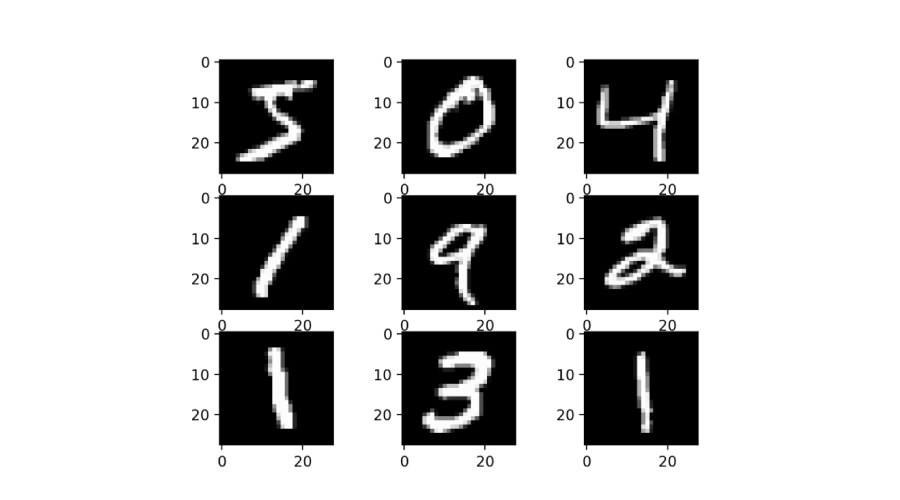

In [ ]:
Image('https://gitee.com/honghanchen/2025-ai/raw/master/experiment1/images/mnist1.jpg')

### <font color=blue> 3.1 训练和测试数据及其标签 </font>

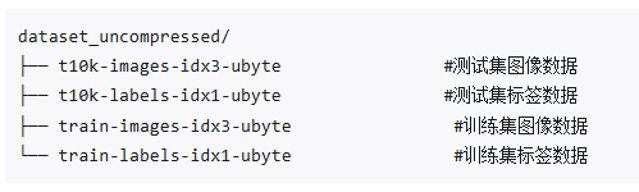

In [ ]:
Image('https://gitee.com/honghanchen/2025-ai/raw/master/experiment1/images/uzipMNIST.png')

Pytorch的trochvision Dataset自带MNIST数据集和下载，自己下载的MNIST解压开大概会有上图4个部分：
1. `x_train`：用于训练神经网络的图像 train-images-idx3-ubyte
2. `y_train`：正确的 `x_train` 图片标签，用于在训练期间评估模型的预测 train-labels-idx3-ubyte
3. `x_test`：单独留出来的图像，用来在训练模型后测试模型的性能 t10k-images-idx3-ubyte
4. `y_test`：正确的 `x_test` 图像标签，用于在训练模型后评估模型的预测 t10k-labels-idx3-ubyte

### <font color=blue> 3.2 使用Pytorch的TorchVision加载数据集 </font>

In [8]:
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)
# torchvision.datasets自带多个常用的公开数据集
# train=True表示是训练数据, 为False表示为测试/验证数据
# download=True表示自动下载
# train_set 和 valid_set 是分别加载的训练集和验证集

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.20MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.12MB/s]


In [9]:
# 执行这里可以查看训练数据集的情况
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

In [10]:
# 执行这里可以查看测试/验证数据集的情况
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

### <font color=blue> 3.3 观察MNIST数据集 </font>

In [11]:
# 取 train_set`的第一个数据，由 x, y 两部分组成：
# 看看他们都是什么内容? 用type()输出一下数据类型看看是什么？
x_0, y_0 = train_set[0]

In [12]:
x_0

In [13]:
type(x_0)

PIL.Image.Image

In [14]:
y_0

5

In [15]:
type(y_0)

int

## <font color=blue> 4.  张量（Tensor） </font>

Pytorch框架中，数据一般都以张量的形式存放和计算，因此在给网络准备训练数据之前，需要对张量有所了解。<br>
简单理解:<br>
1个数通常为标量scalar、一行或一列数位向量row/column vector、二维的为矩阵matrix、高于三维的都可以认为是张量tensor。

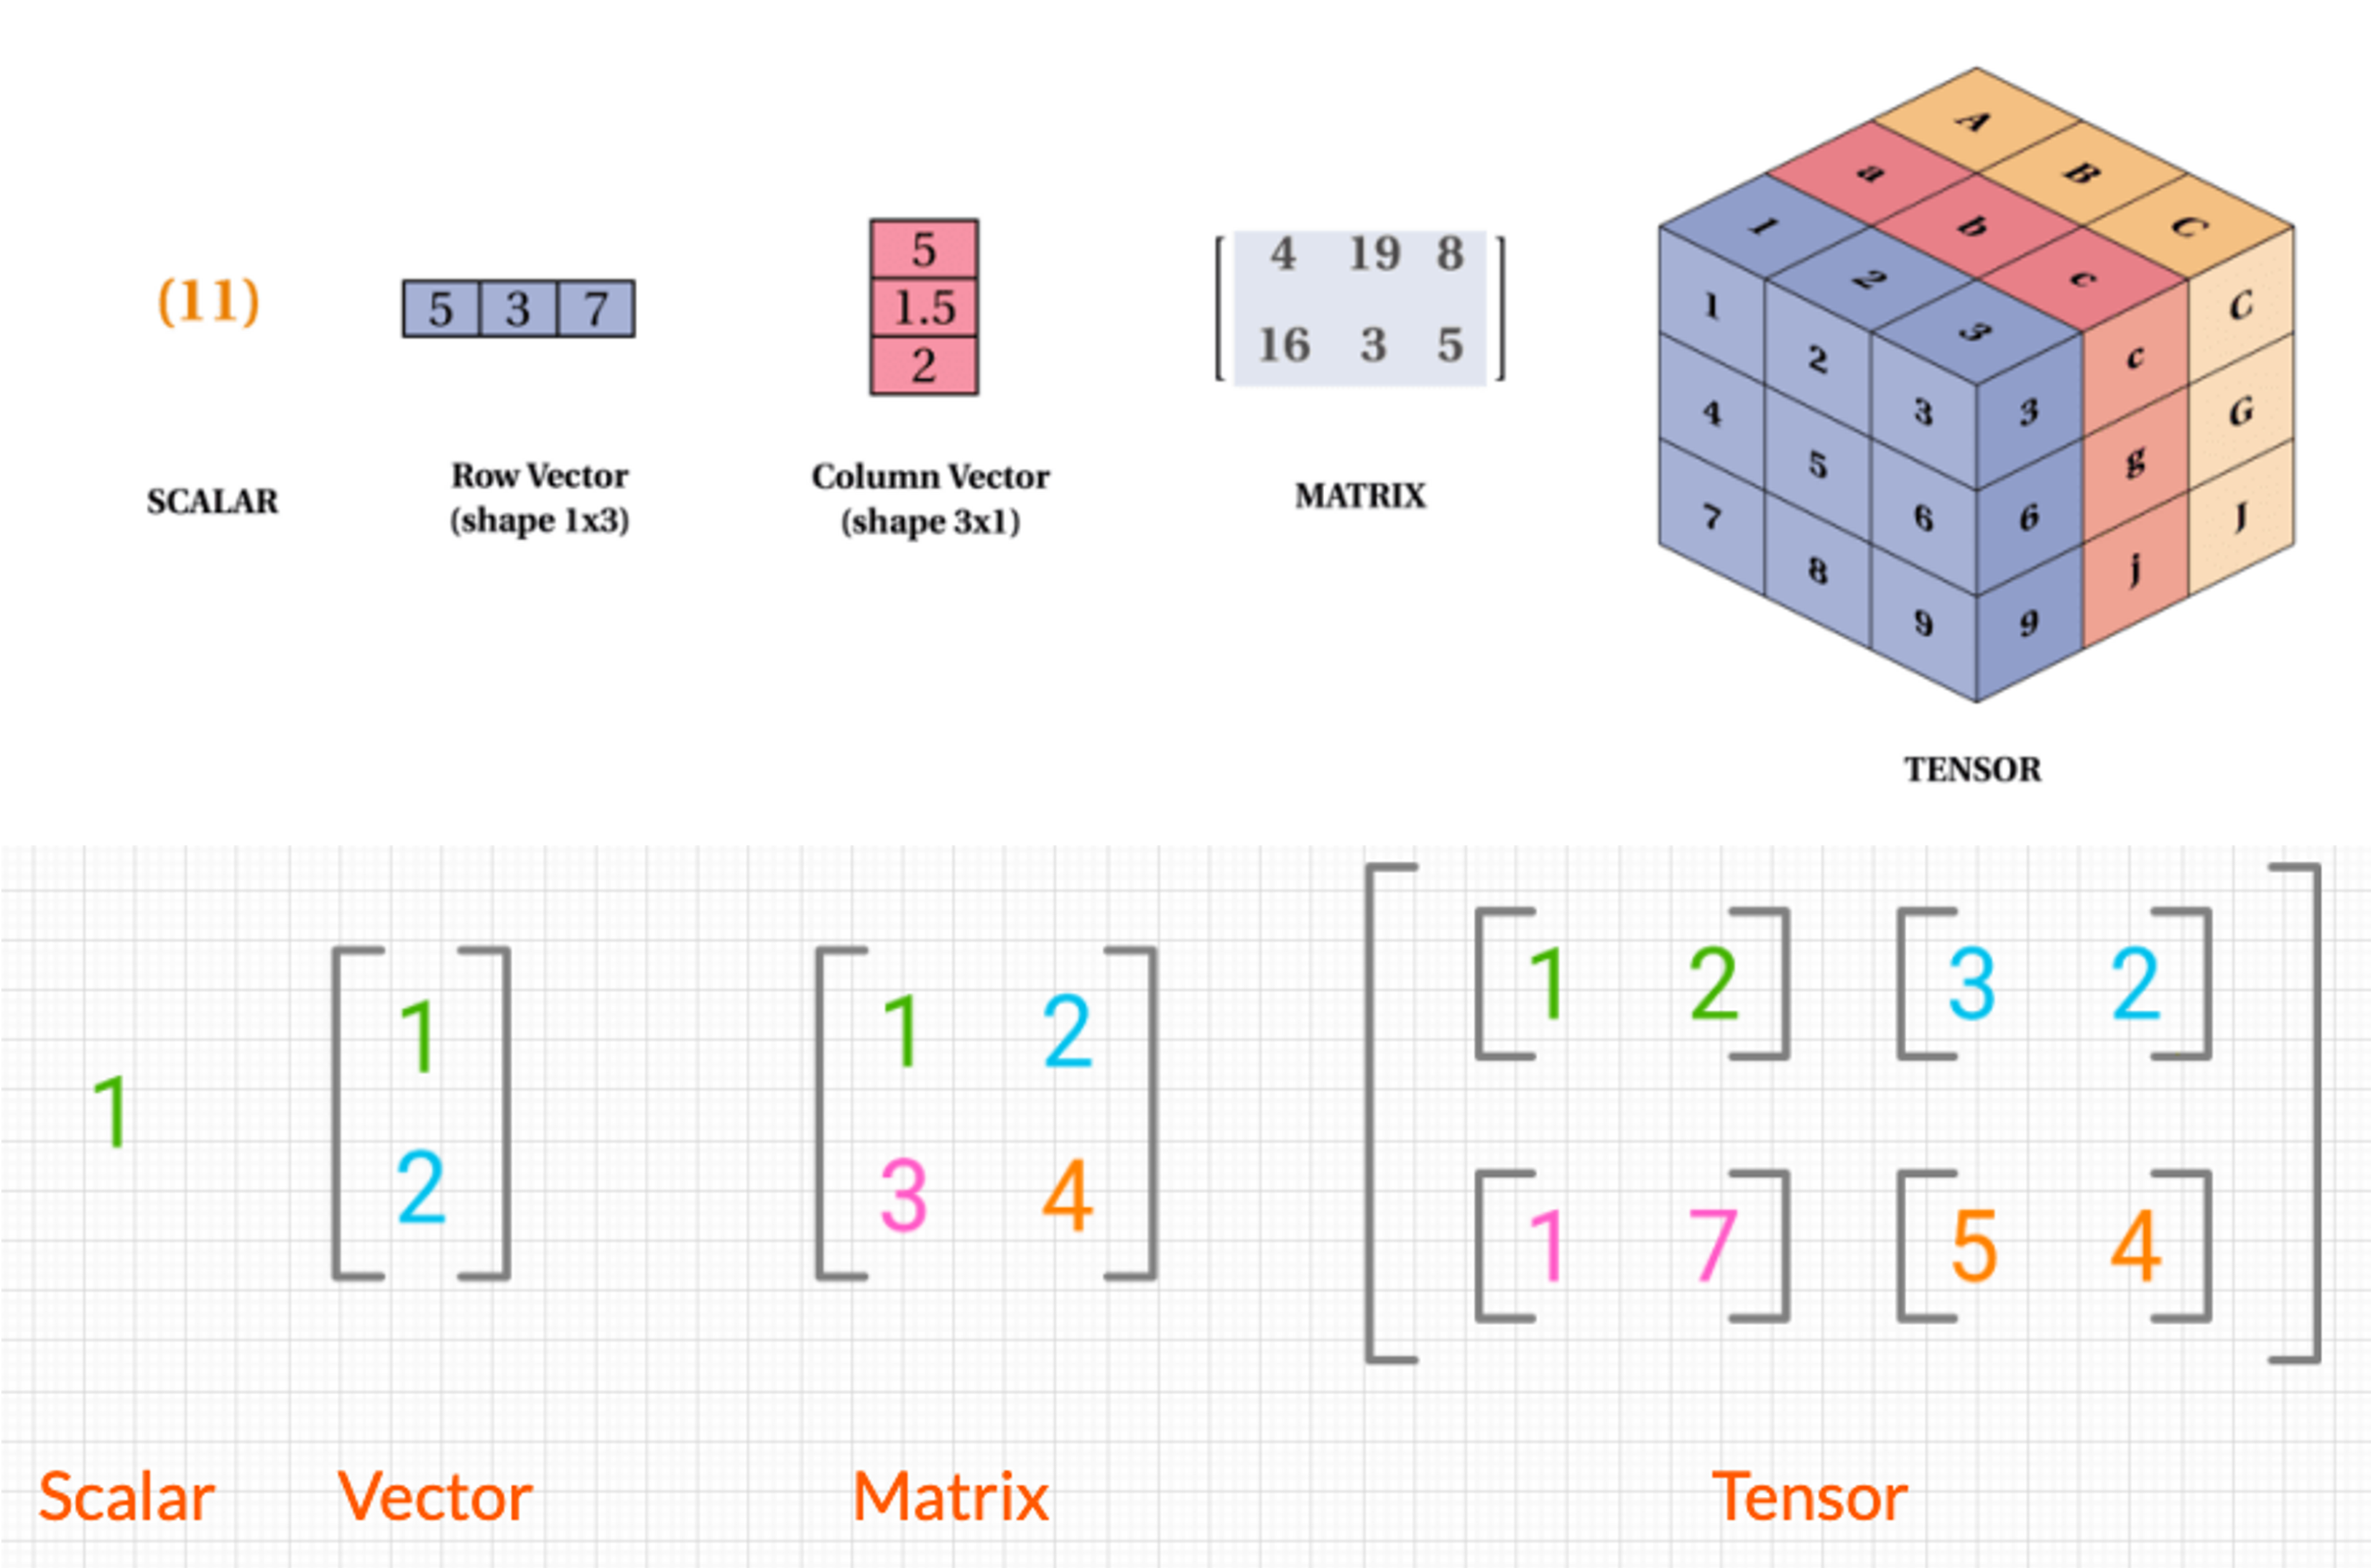

In [ ]:
Image('https://gitee.com/honghanchen/2025-ai/raw/master/experiment1/images/tensor.png')

In [16]:
# pytorch中，数据可以通过数据变换函数transofrms.ToTensor()实现
# 如果数据需要同时进行多种变换，用transforms.Compose后面数据增强实验留意
trans = transforms.Compose([transforms.ToTensor()])
x_0_tensor = trans(x_0)

In [17]:
# 验证数据类型
x_0_tensor.dtype

torch.float32

In [18]:
# 验证最小值和最大值。PIL 图像的整数范围是 [0, 255]，但 ToTensor 类回将其转换为 [0.0, 1.0] 的浮点数范围。
x_0_tensor.min()

tensor(0.)

In [19]:
x_0_tensor.max()

tensor(1.)

In [20]:
# 查看每个维度的大小。PyTorch 用的是 `C x H x W` 表示，这意味着第一个维度是颜色通道，第二个是高度，第三个是宽度。
# 这些图像是灰度图，只有 1 个颜色通道。图像是正方形，高度和宽度都是 28 像素：
x_0_tensor.size()

torch.Size([1, 28, 28])

我们还可以直接查看值：

In [21]:
# 输出观察
x_0_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [22]:
# 张量最初由 CPU 处理。
x_0_tensor.device

device(type='cpu')

In [23]:
# 传递给GPU的方法
x_0_gpu = x_0_tensor.cuda()
x_0_gpu.device

device(type='cuda', index=0)

In [24]:
x_0_tensor.to(device).device

device(type='cuda', index=0)

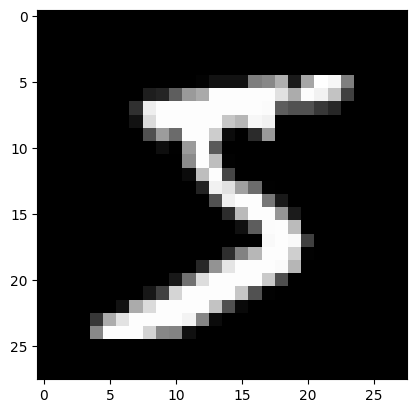

In [25]:
#TorchVision 可以使用 to_pil_image 函数将 C x H x W 格式的张量转换回 PIL 图像。
image = F.to_pil_image(x_0_tensor)
plt.imshow(image, cmap='gray')

## <font color=blue> 5 为模型训练准备(加载)数据 </font>

### <font color=blue> 5.1 数据变换处理（Transforms）</font>

In [26]:
trans = transforms.Compose([transforms.ToTensor()])

In [27]:
# 由于训练和验证数据都需要变换为tensor给网络，因此训练和验证数据集都使用trans变换
# 在后续的实验中数据经过多种复杂变换，训练和验证将会采用不同的变换
train_set.transform = trans
valid_set.transform = trans

### <font color=blue> 5.2 数据加载器（DataLoaders）</font>

In [28]:
# 数据经过变换后需要通过数据加载器送入网络
# 把数据一次全送入网络？(GPU显存不够，装不下那么多)
# 一个一个的送入？(效率低，效果真的好？)
# 而且研究表明使用较小的数据批次（batch）对模型训练更有效
# batch_size 是 32，抽取 32 张卡片来训练我们的模型 shuffle=True就是从数据中打乱随机抽

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## <font color=blue>6. 创建模型 </font>

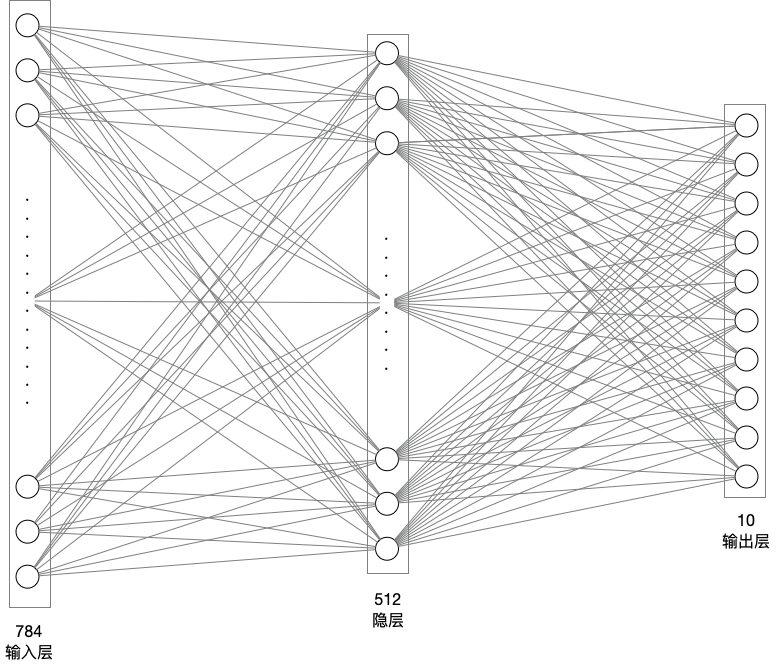

In [ ]:
Image('https://gitee.com/honghanchen/2025-ai/raw/master/experiment1/images/network1.png')

In [29]:
# 准备好训练数据之后，该创建模型了
# 神经网络由多个层组成:
# 1. 一个flatten层，用于将 n 维数据转换为向量。
# 2. 输入层，即第一层神经元
# 3. 隐藏层，即输入和输出之间“隐藏”的另一层神经元
# 4. 输出层，即最后一组神经元，返回模型的最终预测结果
layers = []
layers

[]

### <font color=blue> 6.1 展平图片 </font>

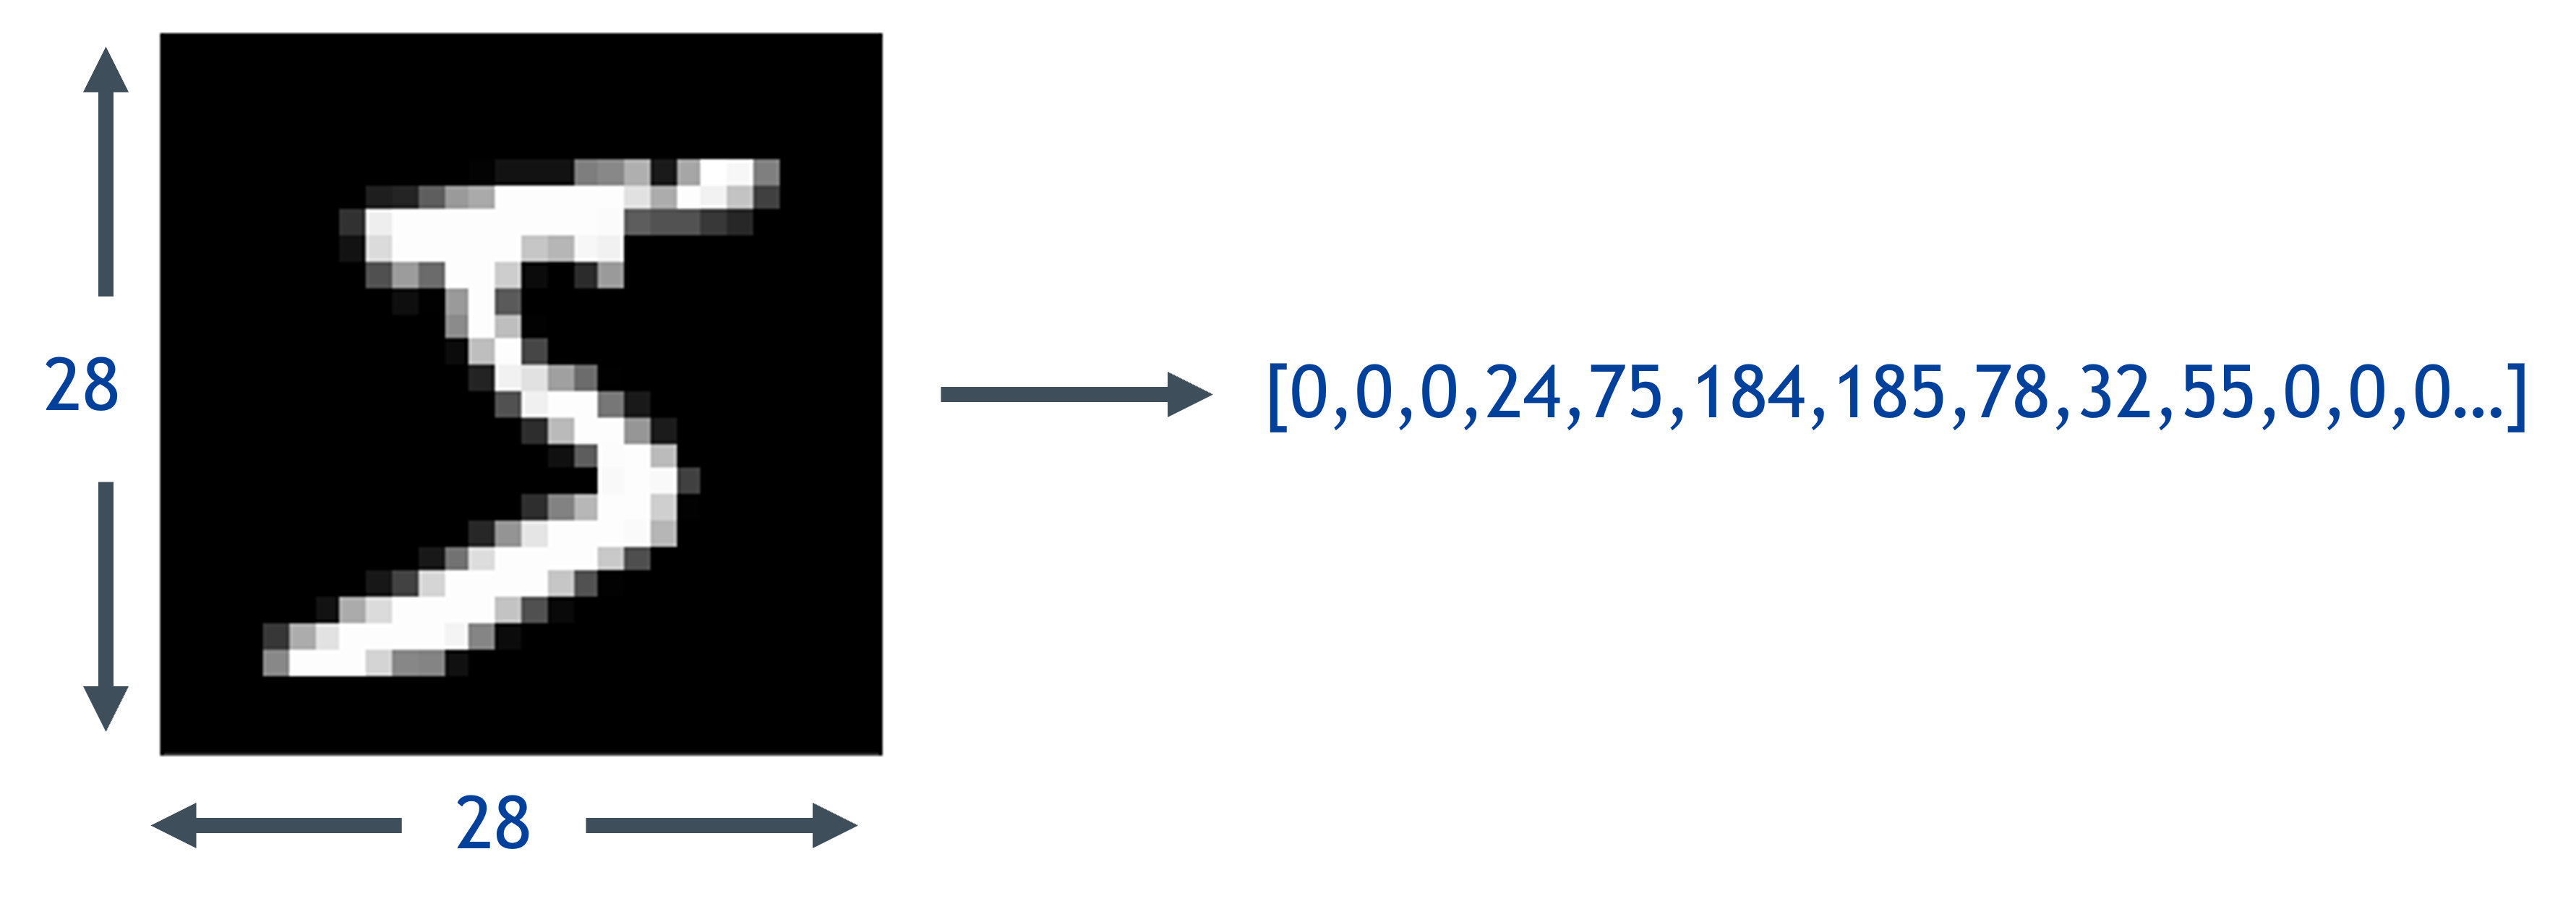

In [ ]:
Image('https://gitee.com/honghanchen/2025-ai/raw/master/experiment1/images/flatten.png')

In [30]:
# 图像有 3 个维度：C x H x W。将图像展平意味着将所有这些维度合并成 1 个维度（向量）
test_matrix = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
)
test_matrix

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [31]:
nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [32]:
test_matrix.shape

torch.Size([3, 3])

In [33]:
# 上述执行后会发现没有变为向量
# Flatten()函数期望的输入为批(batch)数据即(1 x C x H x W) 或 (C x H x W)
# 而我们上面输入的数据是(3 x 3)
# None 可以添加一个新的维度，: 可以选中张量中的所有数据
batch_test_matrix = test_matrix[None, :]
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [34]:
batch_test_matrix.shape

torch.Size([1, 3, 3])

In [35]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

现在我们有了 `Flatten` 层，加到我们的 `layers` 列表中吧。

In [36]:
# Pytorch中，简单的网络可用一个list来逐层堆叠
layers = [
    nn.Flatten()
]
layers

[Flatten(start_dim=1, end_dim=-1)]

### <font color=blue> 6.2 输入层 </font>

In [37]:
# 第一层神经元将展平的图像连接到模型接下来的部分
# 输入层将使用 Linear 层,由于Linear需要确定输入的大小即展平图像的大小
# Linear 层先使用 512 个神经元,可以尝试调整这个数值,看看会影响训练和结果多少
input_size = 1 * 28 * 28

In [38]:
# 输入层之后接 relu 激活函数
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

### <font color=blue> 6.3 隐藏层 </font>

In [39]:
# 添加一个额外的密集连接层
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU()  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

### <font color=blue> 6.4 输出层 </font>

In [40]:
# 添加一个输出层，由于网络需要猜测图像属于 10 个可能类别中的哪一个，因此将有 10 个输出
# 每个输出都分配一个神经元

n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

### <font color=blue> 6.5 编译模型 </font>

In [41]:
# 由于该网络是顺序堆叠的,可以用Sequential进行
# Sequential 输入是参数序列，使用 * operator 将层列表解包成一个序列
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [42]:
# 使用 GPU 进行处理模型，我们可以用 to(device)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [43]:
# 检查模型参数所在的设备
next(model.parameters()).device

device(type='cuda', index=0)

In [45]:
# 对模型进行编译以提高性能
# kaggle平台上模型编译会报错，配置较麻烦, 模型编译这里注释
# model = torch.compile(model)

## <font color=blue>7. 训练模型 </font>

### <font color=blue> 7.1 损失和优化 </font>

In [46]:
# 使用 CrossEntropy 损失函数
loss_function = nn.CrossEntropyLoss()

In [47]:
# 为模型选择一个优化器
optimizer = Adam(model.parameters())

### <font color=blue> 7.2 计算准确率 </font>

In [48]:
# 为了计算准确率，比较正确分类的数量与总预测数量
# 由于以批次的方式向模型输入数据，因此准确率也可以按批来计算
# 总预测数量与我们数据集的大小相同数据集的大小设为 N
# n 作为批大小
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

In [49]:
# 创建一个函数来计算每个批次的准确率
# 其结果是总准确率的一部分，因此将每个批次的准确率相加就可以得到总准确率。
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### <font color=blue> 7.3 训练函数 </font>

In [50]:
# 下方代码是我们根据训练数据定义的训练模型的函数
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### <font color=blue> 7.4 验证函数 </font>

同样，这段代码用于验证模型在未训练数据上的表现。你能发现与 `train` 函数的一些区别吗？

In [51]:
# 验证模型代码
def validate():
    loss = 0
    accuracy = 0

    model.eval()  # 注意这里
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### <font color=blue> 7.5 训练循环 </font>

为了查看模型的进展情况，我们将在训练和验证之间交替进行。就像学生可能需要多次通过他们的卡来学习所有概念一样，模型也会多次通过训练数据来获得更好的理解。

一个 `epoch` 是对整个数据集的一次完整遍历。让我们训练和验证模型 5 个 epoch，看看它的学习情况。

In [52]:
# 一个 epoch 是对整个数据集的一次完整遍历。让我们训练和验证模型 6 个 epoch,
# 实际数据较大过程中epoch往往会是几十次或上百次
# 训练和验证交替进行, 训练一次epoch,就验证一次查看情况
epochs = 6

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()
print('train complete!')

Epoch: 0
Train - Loss: 380.0492 Accuracy: 0.9389
Valid - Loss: 34.3083 Accuracy: 0.9655
Epoch: 1
Train - Loss: 158.1371 Accuracy: 0.9739
Valid - Loss: 27.6207 Accuracy: 0.9733
Epoch: 2
Train - Loss: 106.2764 Accuracy: 0.9819
Valid - Loss: 25.9354 Accuracy: 0.9764
Epoch: 3
Train - Loss: 83.0970 Accuracy: 0.9851
Valid - Loss: 26.6072 Accuracy: 0.9762
Epoch: 4
Train - Loss: 65.0928 Accuracy: 0.9891
Valid - Loss: 27.3301 Accuracy: 0.9779
Epoch: 5
Train - Loss: 53.0738 Accuracy: 0.9912
Valid - Loss: 24.3775 Accuracy: 0.9817
train complete!


In [53]:
# 可以看到，训练和验证的准确率能够达到97%以上
# 我们再选取前面的图片5来通过网络测试一下看看能识别出来是几?
prediction = model(x_0_gpu)
prediction

tensor([[-20.9973, -11.7767, -14.8410,   3.9288, -25.0327,  16.5350, -11.1699,
         -16.5136, -12.1285,  -6.6505]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [54]:
# 有10个类别的数字图片，输出也是10个神经元，下标(索引)为0-9，
# 能看出上面输出的张量里，第几个数字最大嘛？
# 第 0 个索引是对手写数字 0 的预测，第 1 个索引是对手写数字 1 的预测，依此类推
# 使用 argmax 函数来找到最大值的索引
prediction.argmax(dim=1, keepdim=True)

tensor([[5]], device='cuda:0')

In [55]:
# 预测结果
y_0

5